In [2]:
import gym
import torch
from torch import nn
import numpy as np
from collections import deque, namedtuple
import random
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import time

In [4]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
                    nn.Linear(state_dim, 32),
                    nn.ReLU(),
                    nn.Linear(32,8),
                    nn.ReLU(),
                    nn.Linear(8,action_dim)
                    )
    def forward(self, x):
        return self.net(x)

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity 
        self.memory = deque(maxlen = self.capacity)
    
    def update(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    


In [12]:
class DQNAgent:
    def __init__(self, env, mem_capacity, n, eps_max = 1.0, eps_min = 0.1):
        self.env = env
        self.n_episodes = n
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = 7
        self.actions = [-5,-3,-1,0.,1,3,5]
        self.model = DQN(self.state_dim, self.action_dim)
        self.target_model = DQN(self.state_dim, self.action_dim)
        self.memory = ReplayMemory(mem_capacity)
        self.rewards = []
        self.losses = []
        self.eps = lambda x: max(0.1, eps_max - x*(eps_max-eps_min)/n)
        self.optimizer = torch.optim.Adam(self.model.parameters())
             
    def train(self):
        
        self.fill_memory()
        step = 0
        
        pbar = tqdm(total=self.n_episodes, position=0, leave=True)
        for episode in range(self.n_episodes):
            state = self.env.reset()
            is_done = False
            total_rewards = 0
              
            while not is_done:
                if random.random() < 0.1:#self.eps(episode):
                    action = random.sample(range(len(self.actions)), 1)[0]  # choose randomly
                else:
                    with torch.no_grad():
                        action = self.model(torch.from_numpy(state).float()).max(0)[1].item()
                
                
                next_state, reward, is_done, _ = self.env.step(np.array([self.actions[action]]))
                
                total_rewards += reward
                        
                self.memory.update(torch.from_numpy(state), 
                               torch.tensor([action]),  
                               torch.tensor([reward]), 
                               torch.from_numpy(next_state))
                
                batch = self.memory.sample(32)
                loss = self.update_model(batch)
                
                if step % 20  == 0:
                    self.update_target_model()                   
                             
                self.losses.append(loss)    
                step += 1
            self.rewards.append(total_rewards)
            pbar.update()
                
        
    def update_model(self, n_batch):
        gamma = 0.99
        
        batch = Transition(*zip(*n_batch))
               
        rewards = torch.cat(batch.reward)
        
        non_terminal_indices = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)))
        
        next_states = torch.stack([ns for ns in batch.next_state if ns is not None]).float()
        
        max_q = self.target_model(next_states).max(1)[0].detach().double()
        
        
        additional_qs = torch.zeros(32).double()
        
        additional_qs[non_terminal_indices] = max_q
        
        y = rewards.double() + additional_qs * gamma
        y = y.unsqueeze(1)
        # get Q for each action we took in states
        
        actions = torch.stack(batch.action)
        q = self.model(torch.stack(batch.state).float()).gather(1, actions)
        # Update the model
        loss = F.smooth_l1_loss(q, y.float())
        self.optimizer.zero_grad()
        loss.backward()
        #for param in self.model.parameters():
        #    param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        return loss.item()
        
        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
                
    def fill_memory(self, size = 32):
        state = self.env.reset()
        for _ in range(size):
            action = random.sample(range(len(self.actions)), 1)
            next_state, reward, is_done, _ = self.env.step(np.array([self.actions[action[0]]]))
            self.memory.update(torch.from_numpy(state), 
                               torch.tensor(action), 
                               torch.tensor([reward]), 
                               torch.from_numpy(next_state))
            state = next_state
        
    def test(self):
        state = self.env.reset()
        is_done = False
        while not is_done:
            action = self.model(torch.from_numpy(state).float()).max(0)[1].item()
            next_state, reward, is_done, _ = self.env.step(np.array([self.actions[action]]))
            state = next_state
            env.render()
            time.sleep(0.1)

In [13]:
MEM_CAPACITY = 10_000
MAX_EPISODES = 2000

env = gym.make("Pendulum-v0")

agent = DQNAgent(env, MEM_CAPACITY, MAX_EPISODES)
agent.train()

100%|██████████| 2000/2000 [13:18<00:00,  2.64it/s]

In [421]:
state = agent.env.reset()
agent.model(torch.from_numpy(state).float()).max(0)[1]

tensor(0)

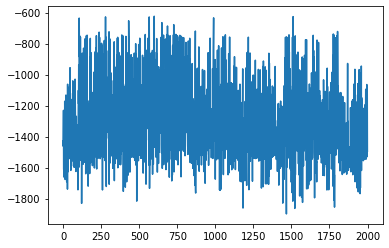

In [15]:
from matplotlib import pyplot as plt
plt.plot(agent.rewards)
#plt.plot(agent.losses)po 

In [17]:
agent.test()
agent.env.close()

In [346]:
batch = agent.memory.sample(32)
n_batch = Transition(*zip(*batch))

In [503]:
agent.env.observation_space

Box(-8.0, 8.0, (3,), float32)

In [31]:
env = gym.make("Pendulum-v0")
env.reset()
env.step([0])

(array([0.81732838, 0.57617213, 1.0906185 ]), -0.36100913083374336, False, {})

In [169]:

agent.model(torch.stack(batch.state).float())

AttributeError: 'list' object has no attribute 'state'

In [186]:
t = torch.tensor([[1,2,3],[4,5,6]])
torch.gather(t, 1, torch.tensor([[1],[1]]))

tensor([[2],
        [5]])

In [175]:
t

tensor([[1, 2],
        [3, 4]])